# Navarro Quant

This notebook generates a figure showing the difference in quantification between searches of Navarro data with or without extra decoys.

In [1]:
import pandas as pd

from sqlite3 import connect

import re

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.cm import get_cmap

import numpy as np

from scipy.stats import gaussian_kde

from itertools import cycle

In [2]:
%matplotlib inline

In [3]:
def extract_peptide_data(file, cutoff=0.01):
    try:
        db = connect(file)
        
        return pd.read_sql_query(
            '''
            select
                q.precursorcharge
                ,q.peptidemodseq
                ,q.peptideseq
                ,min(p2p.isdecoy) decoy
                ,group_concat(p2p.ProteinAccession, ';') proteinIds
                ,q.sourcefile
                ,q.totalintensity intensity
                ,s.qvalue
            from peptidequants q
            left join peptidetoprotein p2p using (peptideseq)
            left join peptidescores s using (peptidemodseq)
            group by q.peptidemodseq, q.precursorcharge, q.sourcefile
            having not decoy
            and q.totalintensity > 0
            and min(s.qvalue) <= 
            ''' + str(cutoff)
            ,db
        )
    finally:
        db.close()

def extract_protein_data(file, sep='\t'):
    return pd.read_csv(file, sep=sep)

In [4]:
normal_decoy = '../data/navarro/navarro-blib/quant_results.elib'

extra_decoy = '../data/navarro/navarro-blib-extra-decoys/quant-results.elib'

normal_peptide_data = extract_peptide_data(normal_decoy)

extra_peptide_data = extract_peptide_data(extra_decoy, cutoff=0.0198)

In [5]:
len(normal_peptide_data)

59980

In [6]:
len(extra_peptide_data)

60542

In [7]:
normal_protein_data = extract_protein_data('../data/navarro/navarro-blib/quant_results.elib.proteins.txt')

extra_protein_data = extract_protein_data('../data/navarro/navarro-blib-extra-decoys/quant-results.elib.proteins.txt')

In [8]:
homo_patt = re.compile('^(sp|tr)\|[\w\d]+\|[\w\d]+_HUMAN(;(sp|tr)\|[\w\d]+\|[\w\d]+_HUMAN)*$')
yeas_patt = re.compile('^(sp|tr)\|[\w\d]+\|[\w\d]+_YEAS8(;(sp|tr)\|[\w\d]+\|[\w\d]+_YEAS8)*$')
ecol_patt = re.compile('^(sp|tr)\|[\w\d]+\|[\w\d]+_ECOLI(;(sp|tr)\|[\w\d]+\|[\w\d]+_ECOLI)*$')

In [9]:
# check that our regex-based species checks are exhaustive
#len
(extra_peptide_data[['proteinIds']]
    [  ~extra_peptide_data.proteinIds.str.match(homo_patt)
     & ~extra_peptide_data.proteinIds.str.match(yeas_patt)
     & ~extra_peptide_data.proteinIds.str.match(ecol_patt)
     & ~(
         # these exceptions to the rule allow
         # iRT and shared peptides
         (extra_peptide_data.proteinIds.str.contains('_HUM')&extra_peptide_data.proteinIds.str.contains('_YEA'))
         | (extra_peptide_data.proteinIds.str.contains('_HUM')&extra_peptide_data.proteinIds.str.contains('_ECO'))
         | (extra_peptide_data.proteinIds.str.contains('_ECO')&extra_peptide_data.proteinIds.str.contains('_YEA'))
         | extra_peptide_data.proteinIds.str.match('iRT')
     )
    ])#== 0

proteinIds
4                          SHUFFLE_sp|P37108|SRP14_HUMAN
5                          SHUFFLE_sp|P37108|SRP14_HUMAN
306                         SHUFFLE_sp|P0AG84|YGHA_ECOLI
307                         SHUFFLE_sp|P0AG84|YGHA_ECOLI
366                          SHUFFLE_sp|P0A7V8|RS4_ECOLI
367                          SHUFFLE_sp|P0A7V8|RS4_ECOLI
948                       SHUFFLE_tr|C8ZGF9|C8ZGF9_YEAS8
949                       SHUFFLE_tr|C8ZGF9|C8ZGF9_YEAS8
1024                        SHUFFLE_sp|P77596|YAGF_ECOLI
1025                        SHUFFLE_sp|P77596|YAGF_ECOLI
1140                      SHUFFLE_tr|C8ZA30|C8ZA30_YEAS8
1141                      SHUFFLE_tr|C8ZA30|C8ZA30_YEAS8
1538                        SHUFFLE_sp|Q9Y3D9|RT23_HUMAN
1539                        SHUFFLE_sp|Q9Y3D9|RT23_HUMAN
1741                      SHUFFLE_tr|C8Z3Y1|C8Z3Y1_YEAS8
1742                      SHUFFLE_tr|C8Z3Y1|C8Z3Y1_YEAS8
2101                        SHUFFLE_sp|P0ABD5|ACCA_ECOLI
2102                        SHUFFLE_sp|P0ABD5|ACCA_ECOLI
2254                        SHUFFLE_sp|Q12906|ILF3_HUMAN
2255                        SHUFFLE_sp|Q12906|ILF3_HUMAN
2643                       SHUFFLE_sp|Q8NBJ5|GT251_HUMAN
2644                       SHUFFLE_sp|Q8NBJ5|GT251_HUMAN
2785   reverse_tr|C8Z9H8|C8Z9H8_YEAS8;tr|C8Z9H8|C8Z9H...
2786   reverse_tr|C8Z9H8|C8Z9H8_YEAS8;tr|C8Z9H8|C8Z9H...
2789   reverse_tr|C8Z9H8|C8Z9H8_YEAS8;tr|C8Z9H8|C8Z9H...
2790   reverse_tr|C8Z9H8|C8Z9H8_YEAS8;tr|C8Z9H8|C8Z9H...
2827                        SHUFFLE_sp|P0A9Q7|ADHE_ECOLI
2828                        SHUFFLE_sp|P0A9Q7|ADHE_ECOLI
3047                        SHUFFLE_sp|P35998|PRS7_HUMAN
3048                        SHUFFLE_sp|P35998|PRS7_HUMAN
...                                                  ...
58273  SHUFFLE_sp|P0ACG1|STPA_ECOLI;SHUFFLE_sp|P0ACF8...
58358                     SHUFFLE_tr|C8ZCI2|C8ZCI2_YEAS8
58423                       SHUFFLE_sp|P31120|GLMM_ECOLI
58424                       SHUFFLE_sp|P31120|GLMM_ECOLI
58507                     SHUFFLE_tr|C8ZCU6|C8ZCU6_YEAS8
58508                     SHUFFLE_tr|C8ZCU6|C8ZCU6_YEAS8
58605                     SHUFFLE_tr|C8ZGR3|C8ZGR3_YEAS8
58606                     SHUFFLE_tr|C8ZGR3|C8ZGR3_YEAS8
58673                     SHUFFLE_tr|C8ZJL0|C8ZJL0_YEAS8
58674                     SHUFFLE_tr|C8ZJL0|C8ZJL0_YEAS8
58713                       SHUFFLE_sp|P0ADV7|MLAC_ECOLI
58714                       SHUFFLE_sp|P0ADV7|MLAC_ECOLI
58745  SHUFFLE_tr|C8Z516|C8Z516_YEAS8;SHUFFLE_tr|C8Z7...
58746  SHUFFLE_tr|C8Z516|C8Z516_YEAS8;SHUFFLE_tr|C8Z7...
58785                     SHUFFLE_tr|C8Z9H5|C8Z9H5_YEAS8
58786                     SHUFFLE_tr|C8Z9H5|C8Z9H5_YEAS8
59065                      SHUFFLE_sp|Q9H2U2|IPYR2_HUMAN
59066                      SHUFFLE_sp|Q9H2U2|IPYR2_HUMAN
59615                     SHUFFLE_tr|D3UEL3|D3UEL3_YEAS8
59616                     SHUFFLE_tr|D3UEL3|D3UEL3_YEAS8
59797                       SHUFFLE_sp|Q92466|DDB2_HUMAN
59798                       SHUFFLE_sp|Q92466|DDB2_HUMAN
60044  reverse_sp|Q7KZF4|SND1_HUMAN;sp|Q7KZF4|SND1_HUMAN
60045  reverse_sp|Q7KZF4|SND1_HUMAN;sp|Q7KZF4|SND1_HUMAN
60174                      SHUFFLE_sp|P0A796|K6PF1_ECOLI
60175                      SHUFFLE_sp|P0A796|K6PF1_ECOLI
60408                     SHUFFLE_tr|C8ZBZ3|C8ZBZ3_YEAS8
60409                     SHUFFLE_tr|C8ZBZ3|C8ZBZ3_YEAS8
60464  SHUFFLE_sp|P69910|DCEB_ECOLI;SHUFFLE_sp|P69908...
60465  SHUFFLE_sp|P69910|DCEB_ECOLI;SHUFFLE_sp|P69908...

[990 rows x 1 columns]

## Peptide Analysis

In [10]:
def data_by_sample(df):
    return dict(map(lambda f: (f, df[df.SourceFile == f]), set(df.SourceFile.values)))

In [11]:
normal_peptide_data_by_sample = data_by_sample(normal_peptide_data)
extra_peptide_data_by_sample = data_by_sample(extra_peptide_data)

In [12]:
normal_peptide_data_by_sample.keys() == extra_peptide_data_by_sample.keys()

True

In [13]:
samples = list(normal_peptide_data_by_sample.keys())
samples.sort()

In [14]:
samples

['HYE124_TTOF6600_64var_lgillet_I150211_008.mzML',
 'HYE124_TTOF6600_64var_lgillet_I150211_009.mzML']

In [15]:
def join_intensity_on_peptides(data, samples):
    return data[samples[0]][['PeptideModSeq', 'PrecursorCharge', 'proteinIds', 'intensity']].set_index(['PeptideModSeq', 'PrecursorCharge'])\
        .join(
            data[samples[1]][['PeptideModSeq', 'PrecursorCharge', 'intensity']].set_index(['PeptideModSeq', 'PrecursorCharge'])
            ,lsuffix='_a'
            ,rsuffix='_b'
        )

In [16]:
def compute_peptide_ratios(data, samples):
    join = join_intensity_on_peptides(data, samples)
    
    fcs = pd.concat([join.proteinIds, join.intensity_b.rename('intensity'), (join.intensity_a/join.intensity_b).rename('ratio')], axis=1)
    return fcs[~pd.isna(fcs.ratio)]

In [17]:
normal_fcs = compute_peptide_ratios(normal_peptide_data_by_sample, samples)
extra_fcs = compute_peptide_ratios(extra_peptide_data_by_sample, samples)

In [18]:
partitions = [
    [
        normal_fcs[normal_fcs.proteinIds.str.match(yeas_patt)]
        ,normal_fcs[normal_fcs.proteinIds.str.match(homo_patt)]
        ,normal_fcs[normal_fcs.proteinIds.str.match(ecol_patt)]
    ]
    ,[
        extra_fcs[extra_fcs.proteinIds.str.match(yeas_patt)]
        ,extra_fcs[extra_fcs.proteinIds.str.match(homo_patt)]
        ,extra_fcs[extra_fcs.proteinIds.str.match(ecol_patt)]
    ]
]

In [19]:
labels = ['Yeast', 'Human', 'Ecoli']
colors = ['tab:red', 'tab:green', 'tab:purple']

In [20]:
[[len(fcs) for fcs in row] for row in partitions]

[[7843, 14426, 7357], [7712, 14383, 7373]]

In [21]:
['{:s}: {:d} (normal) vs. {:d} (entrap)'.format(label, len(nfcs), len(efcs)) for nfcs, efcs, label in zip(partitions[0], partitions[1], labels)]

['Yeast: 7843 (normal) vs. 7712 (entrap)',
 'Human: 14426 (normal) vs. 14383 (entrap)',
 'Ecoli: 7357 (normal) vs. 7373 (entrap)']

In [22]:
default_figsize = (5,3.5)

In [23]:
def plot_violin(data, ax=None, figsize=default_figsize, colors=None, base=2, bandwidth='silverman', lwrbnd=1e-4, uprbnd=1e4, npts=256):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    stats = []
    for series in data:
        series = series[np.isfinite(series) & (series > lwrbnd) & (series < uprbnd)]

        median = series.median()

        m,M = series.min(), series.max()

        rng = M - m

        m = max(lwrbnd, m - rng/2)
        M = min(uprbnd, M + rng/2)

        kde = gaussian_kde(np.log(series), bw_method=bandwidth)
        coords = np.linspace(np.log(m), np.log(M), npts)

        vals = kde(coords)

        stats.append({
            'coords': np.exp(coords)
            ,'vals': vals
            ,'mean': None
            ,'median': median
            ,'min': m
            ,'max': M
        })
    
    ax.set_yscale('log', basey=base)
    
    ax.xaxis.set_ticks(np.arange(1, len(data)+1))
    ax.xaxis.set_ticklabels([ser.name for ser in data])
    
    parts = ax.violin(stats, showmeans=False, showmedians=True, showextrema=False)
    
    if colors is not None:
        for shape, color in zip(parts['bodies'], cycle(colors)):
            shape.set_facecolor(color)
            shape.set_edgecolor('black')
            shape.set_alpha(.85)
            
    parts['cmedians'].set_edgecolor('black')
    
    return parts

In [24]:
ymin = 2**-6
ymax = 2**4

/home/seth/python/jupyterlab-venv/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


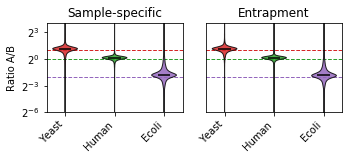

In [25]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.66))

kwds = dict(
    bandwidth='silverman'
    ,npts=1024
    ,colors=colors
)

for data, ax in zip(partitions, axes):
    plot_violin(
        [df.ratio.rename(name) for df, name in zip(data, labels)]
        ,ax=ax
        ,**kwds
    )
    
    ax.set_yscale('log', basey=2)
    
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)

    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])

#fig.suptitle('Peptide Quant Ratio', va='bottom')

fig.tight_layout()

#fig.savefig('img/navarro-ratios.pdf')
fig.show()

In [26]:
def plot_box(data, ax=None, figsize=default_figsize, labels=None, colors=None, base=2, bandwidth='silverman', lwrbnd=1e-4, uprbnd=1e4, npts=256):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    ax.set_yscale('log', basey=base)
    
    ax.xaxis.set_ticks(np.arange(1, len(data)+1))
    ax.xaxis.set_ticklabels([ser.name for ser in data])
    
    parts = ax.boxplot(
        [series[np.isfinite(series) & (series > lwrbnd) & (series < uprbnd)] for series in data]
        ,labels=labels
        ,sym=''
        ,patch_artist=True
    )
    
    if colors is not None:
        for key in ['boxes']:
            for shape, color in zip(parts[key], cycle(colors)):
                shape.set_color(color)
                shape.set_edgecolor('k')
    
    for shape in parts['medians']:
        shape.set_color('k')

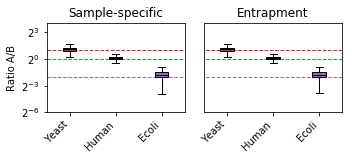

In [27]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.66))

kwds = dict(
    bandwidth='silverman'
    ,npts=1024
    ,labels=labels
    ,colors=colors
)

for data, ax in zip(partitions, axes):
    plot_box(
        [df.ratio for df in data]
        ,ax=ax
        ,**kwds
    )
    
    ax.set_yscale('log', basey=2)
    
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)

    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])

#fig.suptitle('Peptide Quant Ratio', va='bottom')

fig.tight_layout()

#fig.savefig('img/navarro-ratios.pdf')
fig.show()

In [28]:
def plot_scatter(data, ax=None, figsize=default_figsize, colors=None, **kwds):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    i = 0
    for x,y,l in data:
        k=dict(kwds)
        
        if colors is not None:
            k['color']=colors[i % len(colors)]
            i += 1
        
        ax.scatter(x, y, label=l, **k)

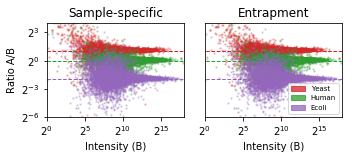

In [29]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.66))

for data, ax in zip(partitions, axes):
    plot_scatter(
        [(df.intensity, df.ratio, name) for df, name in zip(data, labels)]
        ,ax=ax
        ,colors=colors
        ,alpha=.25
        ,s=2
    )
    
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)

    ax.set_xlim((2**0, 2**18))
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')
    
    ax.set_xlabel('Intensity (B)')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])
axes[1].legend([Rectangle((0,0),0,0,fill=True,color=c,alpha=.75) for c in colors], labels, fontsize='x-small', loc='lower right')

fig.tight_layout()

fig.savefig('img/navarro-scatter.pdf')
#fig.show()

In [30]:
join_fcs = normal_fcs.join(extra_fcs, rsuffix='_entrap', how='outer')

In [31]:
for (normal, extra, label) in zip(partitions[0], partitions[1], labels):
    join = normal.join(extra, rsuffix='_entrap', how='outer')
    
    print('''{:d} {:s} peptides have no ratio in normal run
{:d} {:s} peptides have no ratio in entrap run'''.format(
        (pd.isna(join.ratio) & ~pd.isna(join.ratio_entrap)).sum(),
        label,
        (~pd.isna(join.ratio) & pd.isna(join.ratio_entrap)).sum(),
        label
    ))

162 Yeast peptides have no ratio in normal run
293 Yeast peptides have no ratio in entrap run
84 Human peptides have no ratio in normal run
127 Human peptides have no ratio in entrap run
277 Ecoli peptides have no ratio in normal run
261 Ecoli peptides have no ratio in entrap run


In [32]:
cutoff = 1.05
mask = ((join_fcs['ratio'] / join_fcs['ratio_entrap'] > cutoff)\
        & (join_fcs['ratio'] / join_fcs['ratio_entrap'] < (1/cutoff)))\
        | pd.isna(join_fcs['ratio']) | pd.isna(join_fcs['ratio_entrap'])

/home/seth/python/jupyterlab-venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


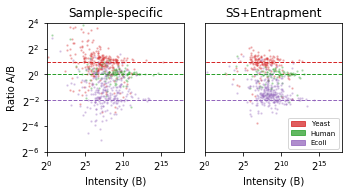

In [33]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.8))

for data, ax in zip(partitions, axes):
    data = map(lambda df: df[mask], data)

    plot_scatter(
        [(df.intensity, df.ratio, name) for df, name in zip(data, labels)]
        ,ax=ax
        ,colors=colors
        ,alpha=.25
        ,s=2
    )
    
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)

    ax.set_xlim((2**0, 2**18))
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')
    
    ax.set_xlabel('Intensity (B)')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('SS+Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])
axes[1].legend([Rectangle((0,0),0,0,fill=True,color=c,alpha=.75) for c in colors], labels, fontsize='x-small', loc='lower right')

fig.tight_layout()

fig.savefig('img/navarro-scatter.pdf')
#fig.show()

## Protein Analysis

In [34]:
normal_protein_data.columns

Index(['Protein', 'NumPeptides', 'PeptideSequences',
       'HYE124_TTOF6600_64var_lgillet_I150211_008.mzML',
       'HYE124_TTOF6600_64var_lgillet_I150211_009.mzML'],
      dtype='object')

In [35]:
extra_protein_data.columns

Index(['Protein', 'NumPeptides', 'PeptideSequences',
       'HYE124_TTOF6600_64var_lgillet_I150211_008.mzML',
       'HYE124_TTOF6600_64var_lgillet_I150211_009.mzML'],
      dtype='object')

In [36]:
sample_a = extra_protein_data.columns[-2]
sample_b = extra_protein_data.columns[-1]

normal_protein_fcs,extra_protein_fcs = map(lambda df: pd.concat([
    df['Protein']
    ,df[sample_b].rename('intensity')
    ,(df[sample_a]/df[sample_b]).rename('ratio')
], axis=1), [normal_protein_data, extra_protein_data])

In [37]:
protein_partitions = [
    [
        normal_protein_fcs[normal_protein_fcs.Protein.str.match(yeas_patt)]
        ,normal_protein_fcs[normal_protein_fcs.Protein.str.match(homo_patt)]
        ,normal_protein_fcs[normal_protein_fcs.Protein.str.match(ecol_patt)]
    ]
    ,[
        extra_protein_fcs[extra_protein_fcs.Protein.str.match(yeas_patt)]
        ,extra_protein_fcs[extra_protein_fcs.Protein.str.match(homo_patt)]
        ,extra_protein_fcs[extra_protein_fcs.Protein.str.match(ecol_patt)]
    ]
]

In [38]:
[[len(fcs) for fcs in row] for row in protein_partitions]

[[1333, 2235, 1165], [1179, 2120, 1048]]

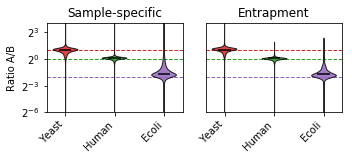

In [39]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.66))

kwds = dict(
    bandwidth='silverman'
    ,npts=1024
    ,colors=colors
)

for data, ax in zip(protein_partitions, axes):
    plot_violin(
        [df.ratio.rename(name) for df, name in zip(data, labels)]
        ,ax=ax
        ,**kwds
    )
    
    ax.set_yscale('log', basey=2)
    
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)

    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])

#fig.suptitle('Peptide Quant Ratio', va='bottom')

fig.tight_layout()

#fig.savefig('img/navarro-protein-ratios.pdf')
fig.show()

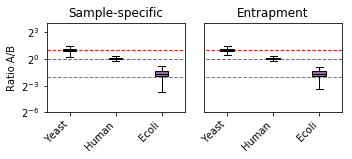

In [40]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.66))

kwds = dict(
    bandwidth='silverman'
    ,npts=1024
    ,labels=labels
    ,colors=colors
)

for data, ax in zip(protein_partitions, axes):
    plot_box(
        [df.ratio for df in data]
        ,ax=ax
        ,**kwds
    )
    
    ax.set_yscale('log', basey=2)
    
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)

    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])

#fig.suptitle('Peptide Quant Ratio', va='bottom')

fig.tight_layout()

#fig.savefig('img/navarro-protein-ratios.pdf')
fig.show()

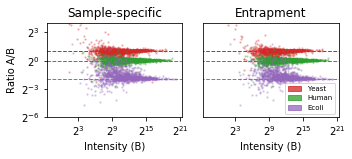

In [41]:
fig, axes = plt.subplots(1,2,figsize=(default_figsize[0], default_figsize[1]*.66))

for data, ax in zip(protein_partitions, axes):
    plot_scatter(
        [(df.intensity, df.ratio, name) for df, name in zip(data, labels)]
        ,ax=ax
        ,colors=colors
        ,alpha=.25
        ,s=2
    )
    
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)

    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Ratio A/B')
    
    ax.set_xlabel('Intensity (B)')

    ax.add_line(Line2D([-1e32, 1e32], [2, 2], color=colors[0], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1, 1], color=colors[1], linestyle='--', linewidth=1, zorder=-99))
    ax.add_line(Line2D([-1e32, 1e32], [1/4, 1/4], color=colors[2], linestyle='--', linewidth=1, zorder=-99))
    
axes[0].set_title('Sample-specific')

axes[1].set_title('Entrapment')
axes[1].set_ylabel(None)
axes[1].set_yticks([])
axes[1].legend([Rectangle((0,0),0,0,fill=True,color=c,alpha=.75) for c in colors], labels, fontsize='x-small', loc='lower right')

fig.tight_layout()

fig.savefig('img/navarro-protein-scatter.pdf')
#fig.show()